In [1]:
import numpy as np
import ot
import scipy.stats as stats
import scipy.spatial.distance as spatial
import matplotlib.pyplot as plt

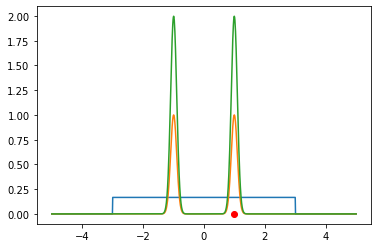

In [2]:
x_true = 1
x_prior_pdf = stats.uniform(-3, 6)
h = lambda x: abs(x)
R = 0.01
y = h(x_true) + np.random.randn()*R
likelihood  = lambda x: np.exp(-0.5*((y-h(x))**2) / R)

N_grid = 1000
grid_min = -5
grid_max = 5
grid = np.linspace(-5, 5, 1000)
plt.plot(grid, x_prior_pdf.pdf(grid))
plt.plot(grid, likelihood(grid))

def bayes(prior, likelihood, dx):
    return prior * likelihood / (dx*np.sum(prior * likelihood))

posterior = bayes(x_prior_pdf.pdf(grid),
                  likelihood(grid), (grid_max-grid_min)/N_grid)

plt.plot(grid, posterior)
plt.plot(x_true, 0, 'r+')
plt.plot(y, 0, 'ro')

In [3]:
def compute_phi(lik_values, n_thresh, phi_old,
                n_precision=0.01, phi_precision=0.01):
    n_eff = 0
    a = phi_old
    b = 1
  
    while abs(n_thresh-n_eff) > n_precision:
        phi = 0.5 * (b + a)
        w = np.power(lik_values, phi)
        w /= np.sum(w)
        n_eff = 1/(np.sum(w**2))

        if n_eff>n_thresh:
            a = phi
        else:
            b = phi
        
        if abs(phi-1)<phi_precision:
            phi = 1
            break
            
        if abs(b-a)<phi_precision:
            break

    return phi

def multinomial_resampling(x, w):
    ne = len(w)
    indexes = np.random.choice(ne, size=ne, p=w)
    return x[:, indexes]

def deterministic_resampling(x, w):
    nx, ne = x.shape
    D = spatial.cdist(x.T, x.T, 'sqeuclidean')
    T = ot.emd(w, np.ones(ne)/ne, D)
    P = ne * T
    return (P.T @ x.T).T

def pcnMCMC_mutation(x, likelihood, phi, noise,
                     n_mcmc=10, beta=0.045):
    nx, ne = x.shape

    for j in range(ne):
        for k in range(n_mcmc):
            xprop = np.sqrt(1-beta**2) * x[:, j] + beta*noise.rvs()
            likelihood_ratio = (np.power(likelihood(xprop), phi) /
                                np.power(likelihood(x[:, j]), phi))
            
            u = np.random.uniform()
            if u < min(1, likelihood_ratio):
                x[:, j] = xprop
    
    return x

def TPF_analysis(xf, likelihood, x_prior, n_thresh=None, n_mcmc=10,
                 beta=0.045):
    
    nx, ne = xf.shape
    xa = np.copy(xf)

    phi = 0
    phi_old = 0

    if n_thresh is None:
        n_thresh = ne // 1.85

    i = 0
    while True :
        i = i+1

        # Compute likelihood values
        likelihood_values = np.array([likelihood(xa[:, j]) for j in range(ne)])
        
        # Compute phi
        phi = compute_phi(likelihood_values, n_thresh, phi_old)

        # Compute weights
        w = np.power(likelihood_values, phi-phi_old)
        w = w.reshape(ne)
        w /= np.sum(w)

        # Resample
        xa = deterministic_resampling(xa, w)
        
        # Mutation
        xa = pcnMCMC_mutation(xa, likelihood, phi, x_prior,
                              n_mcmc=n_mcmc, beta=beta)

        if phi == 1:
            break
        else:
            phi_old = phi
        
    print(i, 'tempering iteraions')
        
    return xa

In [4]:
phi = [0]

ne = 100
nmu = 10
beta = 0.045
nx = 1

x = np.zeros((nx, ne, 1))
x[:, :, 0] = x_prior_pdf.rvs(ne)

N_thresh = ne // 1.85

i = 0
while True :
    i = i+1
   
    # Compute phi
    phi.append(compute_phi(likelihood(x[:, :, i-1]), N_thresh, phi[-1]))

    # Compute weights
    w = np.power(likelihood(x[:, :, i-1]), phi[-1]-phi[-2])
    w = w.reshape(ne)
    w /= np.sum(w)

    # Resample
    x_resampled = deterministic_resampling(x[:, :, i-1], w)
    x = np.append(x,x_resampled.reshape((nx, ne, 1)), axis=-1)
    
    # Mutation
    x[:, :, i] = pcnMCMC_mutation(x[:, :, i], likelihood,
                                  phi[i], x_prior_pdf)
    
    if phi[-1] == 1:
        break


In [5]:

ne = 100
x_prior = stats.uniform(-3, 6)
xf = x_prior.rvs(ne).reshape((1, ne))

xa = TPF_analysis(xf, likelihood, x_prior)

3 tempering iteraions


(1, 100, 4)


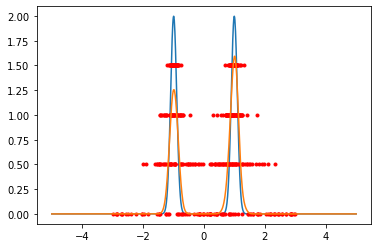

In [7]:
plt.plot(grid, posterior)
print(x.shape)
for i in range(x.shape[-1]):
    plt.plot(x[0, :, i], np.repeat(i, ne)*0.5, 'r.')
plt.plot(grid, stats.gaussian_kde(x[0, :, -1], 0.1)(grid))

In [24]:
%matplotlib qt
fig, ax = plt.subplots(1, 3)
fig.patch.set_visible(False)

for i in range(3):
    tempered_likelihood = lambda x: np.power(likelihood(x), phi[i+1]-phi[i])
    tempered_posterior = bayes(x_prior_pdf.pdf(grid),
                               tempered_likelihood(grid),
                               (grid_max-grid_min)/N_grid)
    
    ax[i].plot(grid, tempered_posterior, label='Análisis temperado')
    ax[i].plot(grid, tempered_likelihood(grid), label='Verosimilitud temperada')
    ax[i].plot(x[0, :, i+1], np.repeat(0, ne)*0.5, 'r|')
    ax[i].axis('off')
    ax[i].set_ylim(-0.1, 2)

ax[1].legend()

In [106]:
plt.plot(grid, posterior)
plt.plot(x[0, :, -1], np.zeros(ne), 'r.')

(10, 10) (2, 10)
(2, 10)


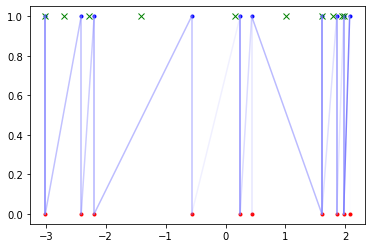

In [118]:
import ot
import ot.plot
n = 10
p1 = np.zeros(2)
s1 = np.array([[5, 0], [0, 0]])
xs = stats.multivariate_normal(p1, s1, allow_singular=True).rvs(n).T
xt = np.copy(xs)

w = abs(np.random.randn(n)*2)
b, a = np.ones((n,)) / n, w/np.sum(w)

M = ot.dist(xs.T, xs.T, metric='sqeuclidean')
# M /= M.max()
G0 = ot.emd(a, b, M)

plt.plot(xs[0, :], xs[1, :],  'r.')
plt.plot(xs[0, :], xs[1, :]+1,  'b.')
print(G0.shape, xs.shape)
xt = (n*G0.T @ xs.T).T
print(xt.shape)
plt.plot(xt[0, :], xt[1, :]+1,  'gx')
ot.plot.plot2D_samples_mat(xs.T, xs.T+np.array([0, 1]), G0, c=[.5, .5, 1])